In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as si
import scipy.special as ss
import scipy.stats as st
from scipy.fftpack import fft, ifft

In [2]:
class profile():
    def __init__(self,amp_arr,mean_arr, sd_arr,period=100,wn_sigma=.03,nbins=512):
        self.amp = amp_arr
        self.mean_arr = mean_arr
        self.sd_arr = sd_arr
        self.nbins = nbins #phase bins
        self.p = period #in ms, not imp rn
        self.domain = np.linspace(0,self.p,num=self.nbins)
        self.d_profile = []
        self.wn_sigma = wn_sigma

    def gaussian_pdf(self,domain,mu,sd):
        return (2*np.pi*sd**2)**(-1/2) * np.exp(-(domain-mu)**2 / (2*sd**2))

    def construct_profile(self,noise=False):
        profile = np.zeros(self.nbins)
        for ind,m in enumerate(self.mean_arr):
            profile += self.amp[ind]*self.gaussian_pdf(self.domain, m, self.sd_arr[ind])
        
        if noise:
            profile += np.random.randn(len(profile)) * self.wn_sigma #multiply by desired sigma
            
        self.profile = profile#/profile.sum()#normalize
    
    def derivative(self):
        if len(self.profile) > 0:
            d_profile = []
            for i in range(len(self.profile)-1):
                d_profile.append((self.profile[i+1]-self.profile[i])/(self.p/self.nbins))
                
            self.d_profile = np.array(d_profile)
        else:
            print('Need to create profile array first!')
    
    def plot(self, derivative=False):
        '''To plot derivative, need to have called object.derivative() first'''
        if derivative:
            x = self.domain.tolist()
            del x[-1]
            plt.plot(x,self.d_profile)
            plt.xlabel("Time(ms)")
            plt.ylabel("Relative intensity Derivative")
            plt.title('Profile Derivative')
            plt.show()
        else:
            plt.plot(self.domain,self.profile)
            plt.xlabel("Time(ms)")
            plt.ylabel("Relative intensity")
            plt.title('Profile')
            plt.show()
            
    #possible speeding up by binary algorithm to choose values of crit
    def noise_stats(profile, N, err=0.5):  
        '''Compute sample mean and standard 
        deviation of off-pulse region given
        any profile. This method assumes
        1) Noise is Gaussian
        2) Profile is offset such that the true
        mean of said Gaussian noise is zero.
        This means when using this method on 
        ratio of profiles, one needs to do
        
        ratio = (profile1+1)/(profile2+1) 
        noise_stats(ratio-1)
        
        +1 to avoid dividing by zero
        
        N: Number to divide max value of 
        flux density by, hence choosing interval
        width to decrease critical flux density
        per loop
        
        err: Maximum range of skewness and 
        kurtosis about the values for a normal
        distribution.
        '''
        
        crit = np.max(profile)
        delta = crit/N
        kurt = st.kurtosis(profile)
        skew = st.skew(profile)
        
        while (np.abs(kurt) > err) or (np.abs(skew) > err):
            noise = [i for i in profile if np.abs(i) <= crit]
            kurt_p = kurt
            skew_p = skew
            kurt = st.kurtosis(noise)
            skew = st.skew(noise)
            crit -= delta
        
        plt.hist(noise,bins=100)
        plt.show()
        
        plt.plot(noise)
        plt.title('Critical flux density:{}'.format(crit))
        plt.show()
        print('length of noise:', len(noise))
        print("Delta: {}".format(delta))
        print('Previous kurtosis: {}'.format(kurt_p))
        print('Previous skew: {}'.format(skew_p))
        print("Final kurtosis: {}".format(kurt))
        print("Final skew: {}".format(skew))
        
        return np.mean(noise), np.std(noise)
    


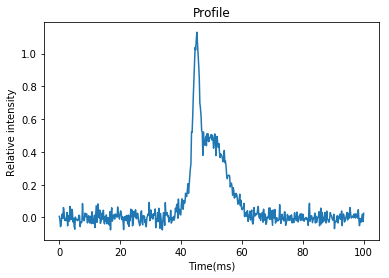

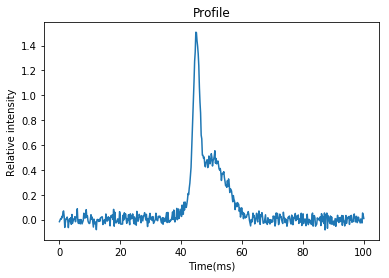

In [3]:
#only change amplitude
a1 = [2,6]
mu1 = [45,50]
sd1 = [1,5]

p1 = profile(a1,mu1,sd1)
p1.construct_profile(noise=True)
p1.plot()

a2 = [3,6]
mu2 = [45,50]
sd2 = [1,5]

p2 = profile(a2,mu2,sd2)
p2.construct_profile(noise=True)
p2.plot()

# Derivative

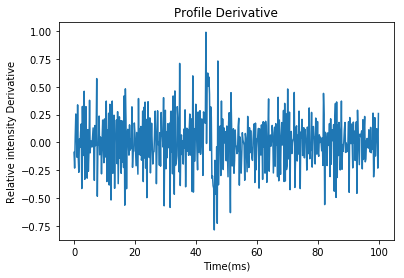

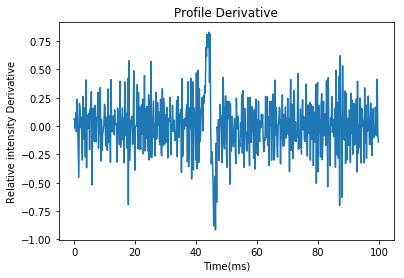

In [4]:
p1.derivative()
p2.derivative()

p1.plot(derivative=True)
p2.plot(derivative=True)

In [5]:
res =  (p1.d_profile) - (p2.d_profile) 

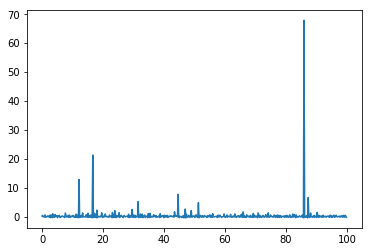

In [6]:
dom = p1.domain.tolist()
del dom[-1]

plt.plot(dom,(res+1)**(-1) - 1)
plt.show()

# ratio

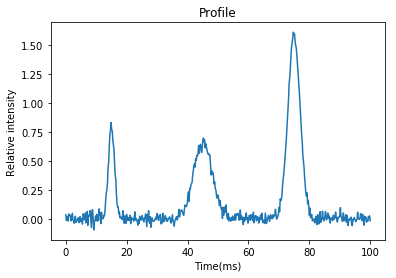

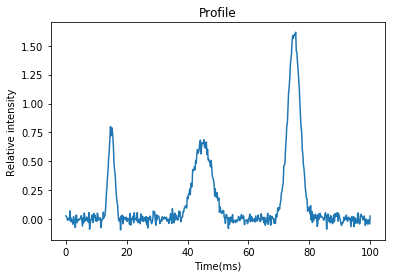

In [28]:
#only change amplitude
a3 = [2,5,8]
mu3 = [15,45,75]
sd3 = [1,3,2]

p3 = profile(a3,mu3,sd3)
p3.construct_profile(noise=True)
p3.plot()

a4 = [2,5,8]
mu4 = [15,45,75]
sd4 = [1,3,2]

p4 = profile(a4,mu4,sd4)
p4.construct_profile(noise=True)
p4.plot()

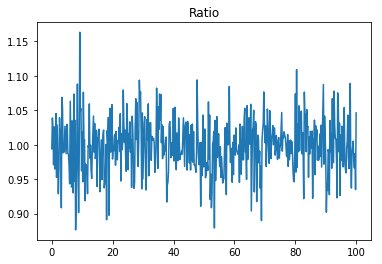

In [29]:
ratio = (p4.profile+1)/(p3.profile+1)
plt.plot(p3.domain, ratio)
plt.title('Ratio')
plt.show()

In [30]:
#calculate chi squared of ratio with off region in ratio
off_region = p3.nbins//5

#cannot use ratio for off pulse region because we cannot assume/guess which regions are purely WN
#off = p3.profile[off_region*4:].tolist() 
#off = np.array(off) + 1
#pline = np.mean(off)

#in the case that we know the WN distribution
pline = 1 #noise ratio sampling distribution mean, this will always be 1 if using ratio method

In [31]:
#the off pulse noise region
#plt.plot(off)
#plt.show()

In [125]:
#chi square test on the ratio against wn
chi = 0
df = p3.nbins-1
for i in range(df):
    chi += (ratio[i] - pline)**2
chi = chi / p3.wn_sigma**2
chi

60174.778180639601

In [126]:
a = df/2
lower = chi**2 / 2

p = ss.gammaincc(a, lower)
print("P( >chi squared): {}%".format(p*100))

P( >chi squared): 0.0%


# Fourier Transform to align phases

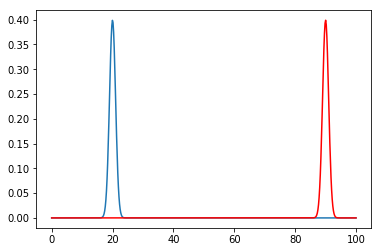

In [261]:
a5 = [1]
mu5 = [20]
sd5 = [1]

a6 = [1]
mu6 = [90]
sd6 = [1]

p5 = profile(a5,mu5,sd5)
p5.construct_profile()
p6 = profile(a6,mu6,sd6)
p6.construct_profile()

y1 = p5.profile
y2 = p6.profile

plt.plot(p5.domain,y1)
plt.plot(p5.domain,y2,'r')
plt.show()

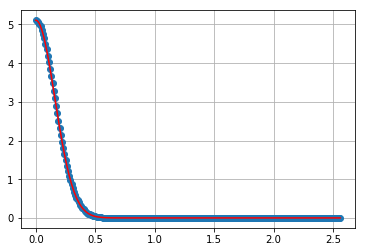

In [262]:
#Turn into frequency domain
yf1 = fft(y1)
yf2 = fft(y2)
N = 512 #sample points
T = 100/512 #sample spacing

xf = np.linspace(0,1/(2*T),N//2)
plt.plot(xf,np.abs(yf1[0:N//2]),marker='o') #factor of 2/N?
plt.plot(xf,np.abs(yf2[0:N//2]),'r')
plt.grid()
plt.show()

/Users/MYK/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


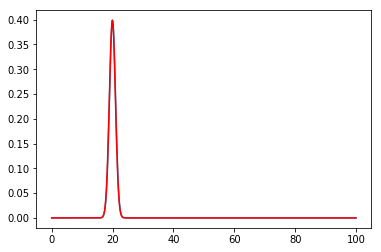

In [264]:
N = p5.nbins
#delay = int(70/p5.p * N) #replace 70 with tau through hulse taylor algorithm

#find delay tau through hulse taylor algorithm, convert tau to nbins



k = np.arange(N)
omega = 2*np.pi*k / N
phase = np.exp(1j*omega*delay)

iy1 = ifft(yf1)
iy2 = ifft(yf2*phase)
plt.plot(p5.domain,iy1)
plt.plot(p5.domain,iy2,'r')
plt.show()

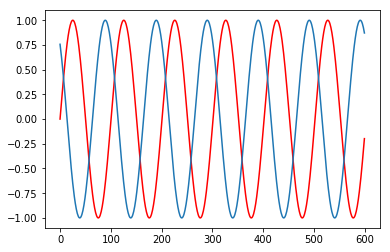

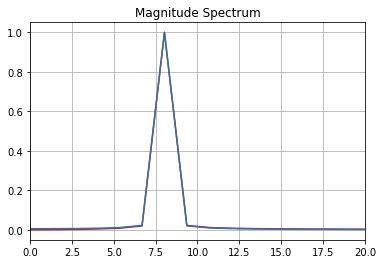

/Users/MYK/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


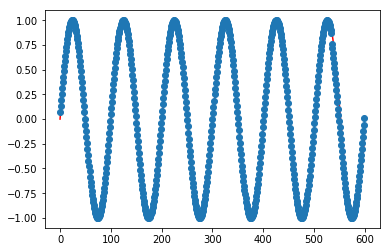

In [246]:
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y1 = np.sin(50*x) 
y2 = np.sin(50*x-4)
yf1 = fft(y1)
yf2 = fft(y2)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.plot(y1,'r')
plt.plot(y2)
plt.show()

def phase(i_arr):
    return np.arctan(np.imag(i_arr) / np.real(i_arr))

plt.plot(xf,2.0/N * np.abs(yf1[0:N//2]),color='r')
plt.plot(xf,2.0/N * np.abs(yf2[0:N//2]))
plt.title('Magnitude Spectrum')
plt.xlim(0,20)
plt.grid()
plt.show()

#p_domain = np.linspace(0,2*np.pi,300)
#plt.plot(p_domain,phase(yf1[0:N//2]),'r')
#plt.plot(p_domain,phase(yf2[0:N//2]))
#plt.title('Phase spectrum')
#plt.grid()
#plt.show()

delay = 65
omega = 2*np.pi*np.arange(N) / N
phase = np.exp(1j*omega*delay)

ift1 = ifft(yf1)
ift2 = ifft(yf2*phase)
#ift2 = ifft(yf2*np.exp(-1j*50*np.pi/2))
plt.plot(ift1,'r')
#plt.show()
plt.plot(ift2,'o')
plt.show()

# Noise sampling

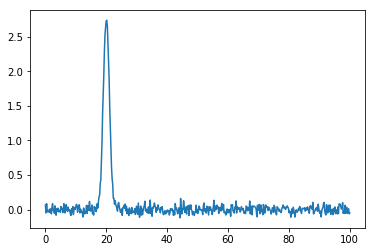

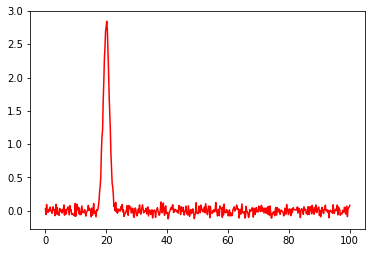

In [4]:
a7 = [7]
mu7 = [20]
sd7 = [1]

a8 = [7]
mu8 = [20]
sd8 = [1]

p7 = profile(a7,mu7,sd7,wn_sigma=.05)
p7.construct_profile(noise=True)
p8 = profile(a8,mu8,sd8,wn_sigma=.05)
p8.construct_profile(noise=True)

y1 = p7.profile
y2 = p8.profile

plt.plot(p7.domain,y1)
plt.show()
plt.plot(p8.domain,y2,'r')
plt.show()

In [5]:
def noise_stats_out(profile,N, err=0.5):  
        '''N: Number to divide max value of 
        flux density by, hence choosing interval
        width to decrease critical flux density
        per loop
        
        err: Maximum range of skewness and 
        kurtosis about the values for a normal
        distribution.
        '''
        
        crit = np.max(profile)
        delta = crit/N
        kurt = st.kurtosis(profile)
        skew = st.skew(profile)
        kurt_p = kurt
        skew_p = skew
        noise = []
        
        while (np.abs(kurt) > err) or (np.abs(skew) > err):
            noise = [i for i in profile if np.abs(i) <= crit]
            kurt_p = kurt
            skew_p = skew
            kurt = st.kurtosis(noise)
            skew = st.skew(noise)
            crit -= delta
        
        plt.hist(noise,bins=100)
        plt.show()
        
        plt.plot(noise)
        plt.title('Off Pulse Flux Density:{}'.format(crit))
        plt.show()
        print('length of noise:', len(noise))
        print("Delta: {}".format(delta))
        print('Previous kurtosis: {}'.format(kurt_p))
        print('Previous skew: {}'.format(skew_p))
        print("Final kurtosis: {}".format(kurt))
        print("Final skew: {}".format(skew))
        
        return np.mean(noise), np.std(noise)

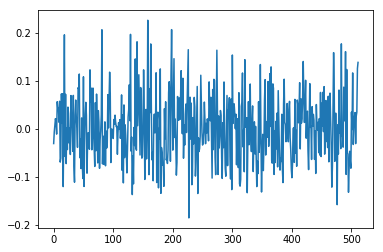

In [6]:
ratio = (p8.profile+1)/(p7.profile+1)
plt.plot(ratio - 1)

#plt.hist(ratio,bins=100)
plt.show()

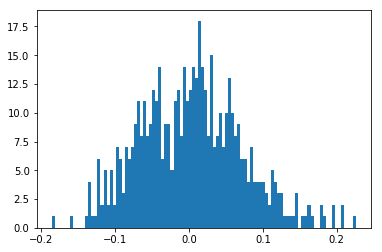

In [7]:
plt.hist((ratio-1),bins=100)
plt.show()

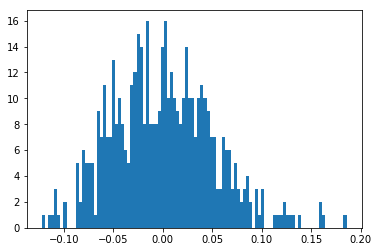

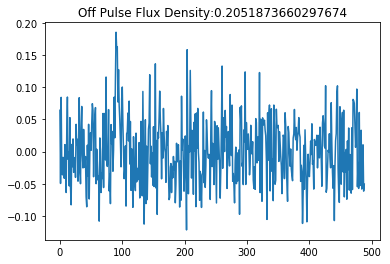

length of noise: 489
Delta: 0.00027394841926531776
Previous kurtosis: 0.5070464130173931
Previous skew: 0.4668663341659712
Final kurtosis: 0.21394578457683755
Final skew: 0.38162591994698564


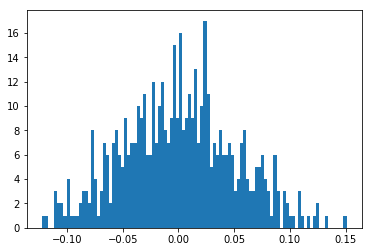

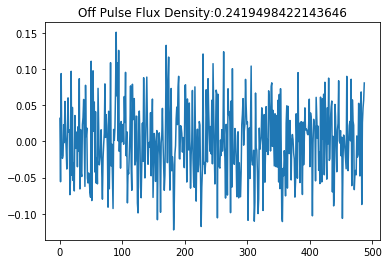

length of noise: 488
Delta: 0.00028464687319302114
Previous kurtosis: 0.4484923584590286
Previous skew: 0.27172649091883955
Final kurtosis: -0.30369672198690045
Final skew: 0.09485333270804092


In [8]:
mu7,sd7 = noise_stats_out(p7.profile,10000,err=.4)
mu8, sd8 = noise_stats_out(p8.profile,10000,err=.4)

In [9]:
mu7,sd7,mu8,sd8

(0.00050940288752098514,
 0.050926442255022873,
 0.00028834866292089153,
 0.050430908337955001)

In [11]:
pline = (mu7+mu8)/2
sd_avg = (sd7**2 + sd8**2)**(.5)
pline,sd_avg

(0.00039887577522093836, 0.071671326460066284)

In [20]:
#chi square test on the ratio against wn
chi = 0
df = p7.nbins-1
for i in range(df):
    chi += ((ratio[i]-1) - pline)**2
chi = chi / sd_avg**2
chi

472.74067447023907

In [19]:
a = df/2
lower = chi**2 / 2

p = ss.gammaincc(a, lower)
print("P( >chi squared): {}%".format(p*100))

P( >chi squared): 0.0%


In [21]:
a = np.random.randn(100)

In [26]:
chi=0
for i in range(len(a)):
    chi += (a[i]-0)**2
chi 

95.087286403688509

In [27]:
ss.gammaincc((len(a)/2), chi**2 / 2)

0.0